In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install SimpleITK

In [0]:
import os
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import numpy.ma as ma
from sklearn.cluster import KMeans
import operator
from scipy.stats import multivariate_normal
from scipy import ndimage

In [0]:
#[1003,1004,1005,1018,2019,1023,1024,1025,1038,1039,1101,1104,107,1110,1113,1116,1119,1122,1125,1128]

testing_image = "1003"

EM_initialization_type = "Kmeans"
#EM_initialization_type = "Label_propagation"
#EM_initialization_type = "Tissue_models"

#Atlas_type = "MNI_Atlas"
Atlas_type = "Generated_Atlas"

#Functions Initialization

##3D image reconstruction function

In [0]:
#This function for remaping the 1D vector to 3D image
def reconstruct_3D_image(ROI_Label, vector_Label):
  out_image = np.zeros(ROI_Label.shape)
  label_dim = 0;
  for dim1 in range(0,ROI_Label.shape[0]):
    for dim2 in range(0,ROI_Label.shape[1]):
      for dim3 in range(0,ROI_Label.shape[2]):
        if(ROI_Label[dim1,dim2,dim3]):
          out_image[dim1,dim2,dim3] = vector_Label[label_dim];
          label_dim = label_dim + 1
  return out_image

##Dice Similarity Function

In [0]:
## Dice Similarity function 

def dice_similarity(Seg_img, GT_img,state):        
    if (state=="nifti"):
       segmented_data = Seg_img.get_data().copy()
       groundtruth_data = GT_img.get_data().copy()
    elif (state=="arr"):
       segmented_data = Seg_img.copy()
       groundtruth_data = GT_img.copy()
    
    #Calculte DICE
    def dice_coefficient(SI,GT):
        intersection = np.logical_and(SI, GT)
        return 2. * intersection.sum() / (SI.sum() + GT.sum())
    
    #Dice  for CSF
    Seg_CSF = (segmented_data == 1) * 1
    GT_CSF = (groundtruth_data == 1) * 1
    dice_CSF = dice_coefficient(Seg_CSF, GT_CSF)
    #Dice  for GM
    Seg_GM = (segmented_data == 3) * 1
    GT_GM = (groundtruth_data == 3) * 1
    dice_GM = dice_coefficient(Seg_GM, GT_GM)
    #Dice  for WM
    Seg_WM = (segmented_data == 2) * 1
    GT_WM = (groundtruth_data == 2) * 1
    dice_WM = dice_coefficient(Seg_WM, GT_WM)
    
    return dice_CSF, dice_GM, dice_WM

##Show Image In Function

In [0]:
def show_image(input_image): 
  rotated_img = ndimage.rotate(input_image, 90)
  plt.imshow(rotated_img, cmap='gray')

# Loading Atlas

In [0]:
if(Atlas_type == "Generated_Atlas"):
  atlas_path = "/content/drive/My Drive/Colab Notebooks/MISA_Lab3/our_atlas_test/"
if(Atlas_type == "MNI_Atlas"):
  atlas_path = "/content/drive/My Drive/Colab Notebooks/MISA_Lab3/MNI_bspline_test/"

CSF_atlas_load = nib.load(atlas_path+"image_"+testing_image+"/CSF/result.nii")
CSF_atlas = CSF_atlas_load.get_fdata()
CSF_atlas_vector = np.reshape(CSF_atlas, CSF_atlas.shape[0]*CSF_atlas.shape[1]*CSF_atlas.shape[2], order='F')
WM_atlas_load = nib.load(atlas_path+"image_"+testing_image+"/WM/result.nii")
WM_atlas = WM_atlas_load.get_fdata()
WM_atlas_vector = np.reshape(WM_atlas, WM_atlas.shape[0]*WM_atlas.shape[1]*WM_atlas.shape[2], order='F')
GM_atlas_load = nib.load(atlas_path+"image_"+testing_image+"/GM/result.nii")
GM_atlas = GM_atlas_load.get_fdata()
GM_atlas_vector = np.reshape(GM_atlas, GM_atlas.shape[0]*GM_atlas.shape[1]*GM_atlas.shape[2], order='F')


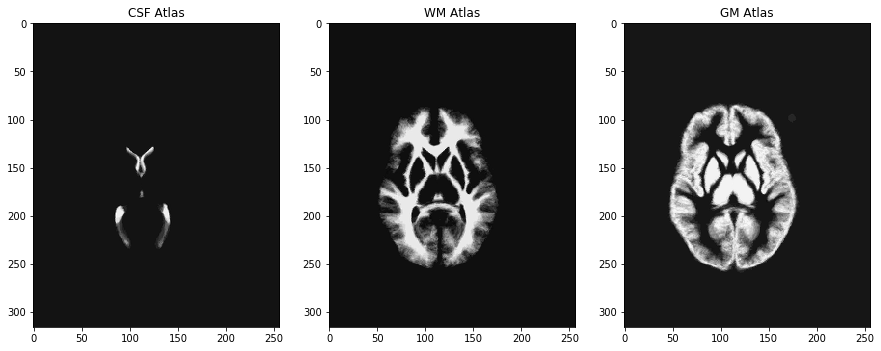

In [9]:
slice_no = 150

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title("CSF Atlas")
show_image(CSF_atlas[:,:,slice_no])
plt.subplot(1,3,2)
plt.title("WM Atlas")
show_image(WM_atlas[:,:,slice_no])
plt.subplot(1,3,3)
plt.title("GM Atlas")
show_image(GM_atlas[:,:,slice_no])

#Loading Test Image

In [0]:
testing_image_path = "/content/drive/My Drive/Colab Notebooks/MISA_Lab3/testing_images/"
testing_labels_path = "/content/drive/My Drive/Colab Notebooks/MISA_Lab3/testing_labels/"
testing_mask_path = "/content/drive/My Drive/Colab Notebooks/MISA_Lab3/testing_mask/"

testing_labels_load = nib.load(testing_labels_path+testing_image+"_3C.nii.gz")
testing_labels = testing_labels_load.get_fdata()
testing_labels_vector = np.reshape(testing_labels, testing_labels.shape[0]*testing_labels.shape[1]*testing_labels.shape[2], order='F')
testing_mask_load = nib.load(testing_mask_path+testing_image+"_1C.nii.gz")
testing_mask = testing_mask_load.get_fdata()
testing_mask_vector = np.reshape(testing_mask, testing_mask.shape[0]*testing_mask.shape[1]*testing_mask.shape[2], order='F')
testing_image_load = nib.load(testing_image_path+testing_image+".nii.gz")
testing_image = testing_image_load.get_fdata()
testing_image_vector = np.reshape(testing_image, testing_image.shape[0]*testing_image.shape[1]*testing_image.shape[2], order='F')
testing_image_roi = np.multiply(testing_image,testing_mask)


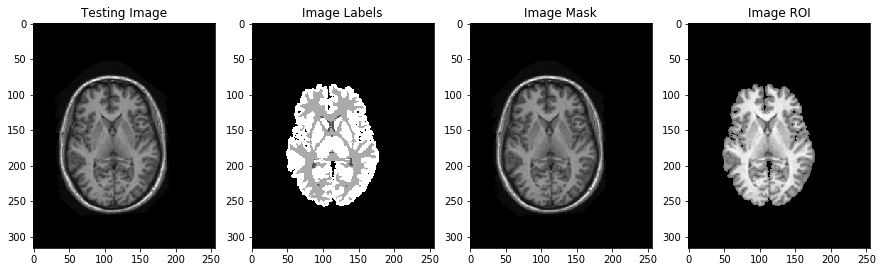

In [11]:
plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.title("Testing Image")
show_image(testing_image[:,:,slice_no])
plt.subplot(1,4,2)
plt.title("Image Labels")
show_image(testing_labels[:,:,slice_no])
plt.subplot(1,4,3)
plt.title("Image Mask")
show_image(testing_image[:,:,slice_no])
plt.subplot(1,4,4)
plt.title("Image ROI")
show_image(testing_image_roi[:,:,slice_no])

#Loading Tissue Models Histogram

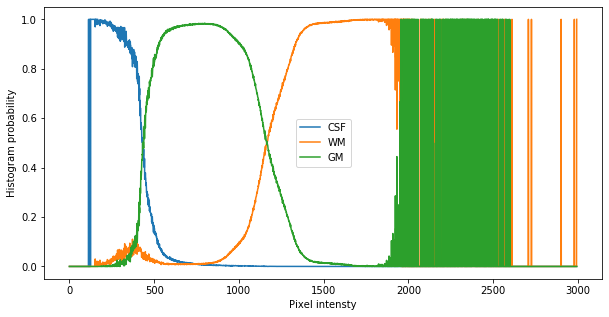

In [12]:

CSF_histogram_norm = np.load("/content/drive/My Drive/Colab Notebooks/MISA_Lab3/tissue_model/CSF_histogram_norm.npy")
WM_histogram_norm = np.load("/content/drive/My Drive/Colab Notebooks/MISA_Lab3/tissue_model/WM_histogram_norm.npy")
GM_histogram_norm = np.load("/content/drive/My Drive/Colab Notebooks/MISA_Lab3/tissue_model/GM_histogram_norm.npy")


plt.figure(figsize=(10,5))
#plt.subplot(1,3,1)
plt.plot(np.arange(np.max(CSF_histogram_norm.shape[0])),CSF_histogram_norm, label = "CSF")
#plt.subplot(1,3,2)
plt.plot(np.arange(np.max(WM_histogram_norm.shape[0])),WM_histogram_norm, label = "WM")
#plt.subplot(1,3,3)
plt.plot(np.arange(np.max(GM_histogram_norm.shape[0])),GM_histogram_norm, label = "GM")


# naming the x axis 
plt.xlabel('Pixel intensty') 
# naming the y axis 
plt.ylabel('Histogram probability') 

# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 


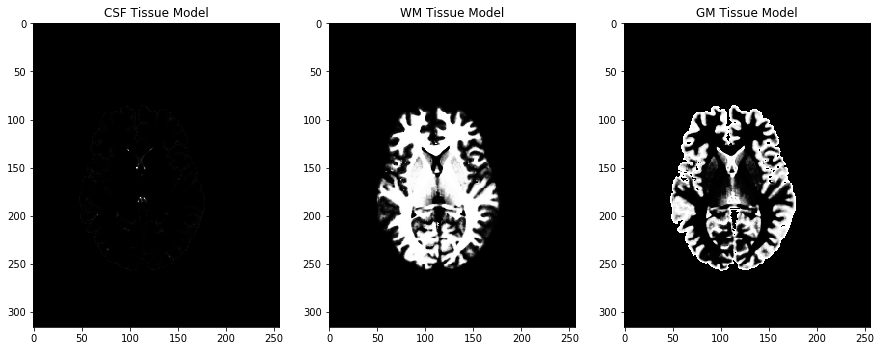

In [13]:
def generate_tissue_model(gray_array_img,label_array_img,label_num):
  if (label_num == 2):
    histogram_norm = WM_histogram_norm
  if (label_num == 3):
    histogram_norm = GM_histogram_norm
  if (label_num == 1):
    histogram_norm = CSF_histogram_norm
  gray_array_img = gray_array_img.astype(int)
  tissue_model_vect = np.zeros(label_array_img.shape[0])
  for i in range(label_array_img.shape[0]):
    if(label_array_img[i] > 0):
      try:
        tissue_model_vect[i] = histogram_norm[gray_array_img[i]]
      except:
        tissue_model_vect[i] = 0
  return tissue_model_vect

GM_tissue_model_vector = generate_tissue_model(testing_image_vector,testing_labels_vector,3)
GM_tissue_model = np.reshape(GM_tissue_model_vector, testing_image.shape, order='F') 

WM_tissue_model_vector = generate_tissue_model(testing_image_vector,testing_labels_vector,2)
WM_tissue_model = np.reshape(WM_tissue_model_vector, testing_image.shape, order='F')

CSF_tissue_model_vector = generate_tissue_model(testing_image_vector,testing_labels_vector,1)
CSF_tissue_model = np.reshape(CSF_tissue_model_vector, testing_image.shape, order='F')

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title("CSF Tissue Model")
show_image(CSF_tissue_model[:,:,slice_no])
plt.subplot(1,3,2)
plt.title("WM Tissue Model")
show_image(WM_tissue_model[:,:,slice_no])
plt.subplot(1,3,3)
plt.title("GM Tissue Model")
show_image(GM_tissue_model[:,:,slice_no])

In [0]:
im_mask = (testing_labels > 0);
testing_image_flatten = ma.array(testing_image_roi,mask=~im_mask).compressed()
X=np.transpose([testing_image_flatten])
testing_labels_flatten = ma.array(testing_labels,mask=~im_mask).compressed()

# Kmeans

Sorted centroids:  [[ 875.53592809]
 [1211.71984704]
 [1622.89208969]]
Kmean Dice: 
 CSF DICE = 0.040628596888575355 GM DICE = 0.5881664507217803 WM DICE = 0.9222300635144672


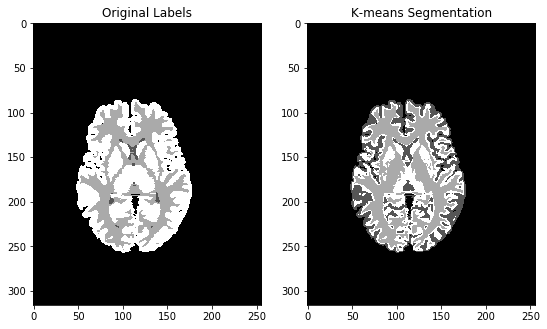

In [15]:
#Kmeans Clustering is used from sklearn.cluster.KMeans
"""
Input: n_clusters= Number of cluster
       K-means++: initial cluster centers for k-mean clustering in a smart way to speed up convergence
       Random State :Determines random number generation for centroid initialization. 
                     Use an int to make the randomness deterministic
Output:
      Kmeans_predict= level index
      Centroid= Mean
""" 
#Kmeans Clustering
kmeans=KMeans(n_clusters=3,  init='k-means++',random_state=0,).fit(X)
Kmeans_predict=kmeans.predict(X)
#print(len(Kmeans_predict))
centroids = kmeans.cluster_centers_


"""
Here the kmeasns is changing the cluster index every time it runs so we make the Keam cluster indexes to a robust format.
"""


##min and max
min_index, min_value = min(enumerate(centroids), key=operator.itemgetter(1))
max_index, max_value = max(enumerate(centroids), key=operator.itemgetter(1))

# Making the Clustering Robust 
#Taking the Shape of the centroid
Shape_Centroid=centroids.shape 
Kmeans_predict_new=np.zeros(len(Kmeans_predict))
centroid_new=np.zeros(Shape_Centroid)

#Centrioid arranging
centroid_new[0]=centroids[min_index]
centroid_new[2]=centroids[max_index]
if (min_index+max_index==1):
   centroid_new[1]=centroids[2]
elif (min_index+max_index==2):
   centroid_new[1]=centroids[1]
elif (min_index+max_index==3):
   centroid_new[1]=centroids[0]

print("Sorted centroids: ",centroid_new)

#New labels
for i in range(0,len(Kmeans_predict)):
    if (Kmeans_predict[i]==min_index):
        Kmeans_predict_new[i]=1
    elif(Kmeans_predict[i]==max_index):
        Kmeans_predict_new[i]=2
    else:
        Kmeans_predict_new[i]=3

Kmeans_output_image = reconstruct_3D_image(testing_mask, Kmeans_predict_new)

plt.figure(figsize=(9,9))
plt.subplot(1,2,1)
plt.title("Original Labels")
show_image(testing_labels[:,:,slice_no])
plt.subplot(1,2,2)
plt.title("K-means Segmentation")
show_image(Kmeans_output_image[:,:,slice_no])

# Calculating Dice
dice_CSF, dice_GM, dice_WM = dice_similarity(Kmeans_output_image,testing_labels,"arr")
print("Kmean Dice: \n CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))

#Expectation Maximization (EM)

##EM parameters initialization

In [0]:
#EM_initialization_type = "Tissue_models"

mu = np.full((3,1), 0) 
co = [[0],[0],[0]]
if(EM_initialization_type == "Kmeans"):
  mu = centroid_new

  Nk = np.array([np.sum(Kmeans_predict_new == 1),np.sum(Kmeans_predict_new == 3),np.sum(Kmeans_predict_new == 2)]);

  membership_weights = np.zeros((X.shape[0], 3))

  membership_weights[:,0] = (Kmeans_predict_new == 1)
  membership_weights[:,1] = (Kmeans_predict_new == 3)
  membership_weights[:,2] = (Kmeans_predict_new == 2)
  
  for i in range(0, 3):
    co[i] = (1/Nk[i])*np.matmul(np.multiply(membership_weights[:,i],(X-mu[i,:]).T),(X-mu[i,:]))

if(EM_initialization_type == "Label_propagation"):
  CSF_atlas_flatten =  ma.array(CSF_atlas,mask=~im_mask).compressed()
  WM_atlas_flatten =  ma.array(WM_atlas,mask=~im_mask).compressed()
  GM_atlas_flatten =  ma.array(GM_atlas,mask=~im_mask).compressed()

  atlas_flatten_array = np.zeros((3,CSF_atlas_flatten.shape[0]),dtype=float)
  atlas_flatten_array[0,:] = CSF_atlas_flatten
  atlas_flatten_array[1,:] = WM_atlas_flatten
  atlas_flatten_array[2,:] = GM_atlas_flatten
  atlas_flatten_array_segmentation = np.argmax(atlas_flatten_array, axis=0)+1

  testing_labels_flatten = ma.array(testing_labels,mask=~im_mask).compressed()

  mu[0,:] = np.mean(ma.array(testing_image_flatten,mask=~(atlas_flatten_array_segmentation==1)).compressed())
  mu[1,:] = np.mean(ma.array(testing_image_flatten,mask=~(atlas_flatten_array_segmentation==3)).compressed())
  mu[2,:]= np.mean(ma.array(testing_image_flatten,mask=~(atlas_flatten_array_segmentation==2)).compressed())

  membership_weights = np.zeros((X.shape[0], 3))
  membership_weights[:,0] = (atlas_flatten_array_segmentation == 1)
  membership_weights[:,1] = (atlas_flatten_array_segmentation == 3)
  membership_weights[:,2] = (atlas_flatten_array_segmentation == 2)

  Nk = np.array([np.sum(atlas_flatten_array_segmentation == 1),np.sum(atlas_flatten_array_segmentation == 3),np.sum(atlas_flatten_array_segmentation == 2)]);

  for i in range(0, 3):
    dummy_var = (X-mu[i]).T

  for i in range(0, 3):
    co[i] = (1/Nk[i])*np.matmul(np.multiply(membership_weights[:,i],(X-mu[i,:]).T),(X-mu[i,:])) 

if(EM_initialization_type == "Tissue_models"):
  CSF_tissue_model_flatten =  ma.array(CSF_tissue_model,mask=~im_mask).compressed()
  WM_tissue_model_flatten =  ma.array(WM_tissue_model,mask=~im_mask).compressed()
  GM_tissue_model_flatten =  ma.array(GM_tissue_model,mask=~im_mask).compressed()

  tissue_model_flatten_array = np.zeros((3,CSF_tissue_model_flatten.shape[0]),dtype=float)
  tissue_model_flatten_array[0,:] = CSF_tissue_model_flatten
  tissue_model_flatten_array[1,:] = WM_tissue_model_flatten
  tissue_model_flatten_array[2,:] = GM_tissue_model_flatten
  tissue_model_flatten_array_segmentation = np.argmax(tissue_model_flatten_array, axis=0)+1

  testing_labels_flatten = ma.array(testing_labels,mask=~im_mask).compressed()

  mu[0,:] = np.mean(ma.array(testing_image_flatten,mask=~(tissue_model_flatten_array_segmentation==1)).compressed())
  mu[1,:] = np.mean(ma.array(testing_image_flatten,mask=~(tissue_model_flatten_array_segmentation==3)).compressed())
  mu[2,:]= np.mean(ma.array(testing_image_flatten,mask=~(tissue_model_flatten_array_segmentation==2)).compressed())

  membership_weights = np.zeros((X.shape[0], 3))

  membership_weights[:,0] = (tissue_model_flatten_array_segmentation == 1)
  membership_weights[:,1] = (tissue_model_flatten_array_segmentation == 3)
  membership_weights[:,2] = (tissue_model_flatten_array_segmentation == 2)

  Nk = np.array([np.sum(tissue_model_flatten_array_segmentation == 1),np.sum(tissue_model_flatten_array_segmentation == 3),np.sum(tissue_model_flatten_array_segmentation == 2)]);

  for i in range(0, 3):
    dummy_var = (X-mu[i]).T

  for i in range(0, 3):
    co[i] = (1/Nk[i])*np.matmul(np.multiply(membership_weights[:,i],(X-mu[i,:]).T),(X-mu[i,:])) 

alpha = np.full((3,1), 1/3) 
#Mixture weights parameters initialization
for i in range(0, 3):
  alpha[i] = Nk[i]/X.shape[0] 
  
number_of_iterations = 100
tol = 0.001

##EM algoritm

Converging in iteration number:  52
EM Dice: 
 CSF DICE = 0.0376060294592524 GM DICE = 0.5348280514244618 WM DICE = 0.9039677323573861


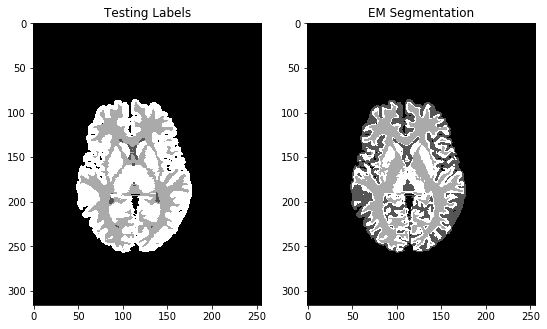

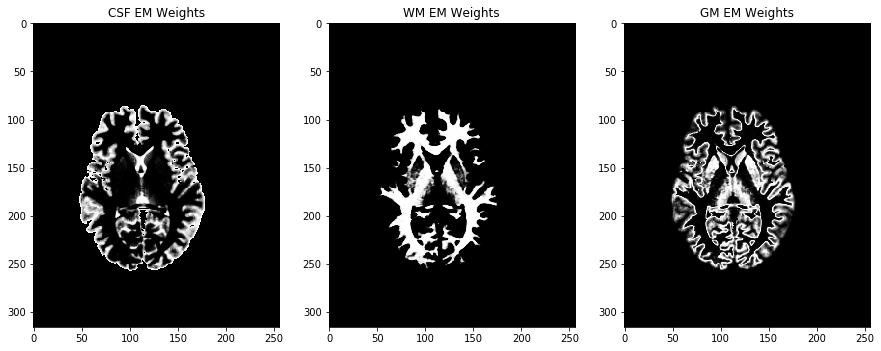

In [17]:
ll_old = 0
for iter_idx in range(1,number_of_iterations+1):
  
  #Calculate the probability using the multivariate GMM equation
  mgd = np.zeros((X.shape[0], 3))
  for i in range(0, 3):
    mgd[:,i] = multivariate_normal(mean=mu[i],cov=co[i]).pdf(X)*alpha[i]

  mgd_sum = np.sum(mgd,axis=1)

    #Calculate the membership weights
  
  for i in range(0, 3):
    membership_weights[:,i] =  np.divide(mgd[:,i],mgd_sum)


  #Calculate the new mixture weights parameters
  Nk = np.sum(membership_weights,axis=0)
  membership_weights = np.where(np.isnan(membership_weights), 1/3, membership_weights) #Replace the nan values with 1/k
  
  ll_new = np.sum(np.log(np.sum(mgd, axis=1))); 
  if np.abs(ll_new - ll_old) < tol:
    break
  ll_old = ll_new 


  for i in range(0, 3):
    mu[i,:] = (1/Nk[i])*np.matmul(np.transpose(membership_weights[:,i]), X);
    co[i] = (1/Nk[i])*np.matmul(np.multiply(membership_weights[:,i],(X-mu[i,:]).T),(X-mu[i,:]))

  

#Predict the EM labels based on the membership weights values
EM_predict = np.zeros((X.shape[0], ))

for i in range(0,membership_weights.shape[0]):
  max_idx = np.where(membership_weights[i,:] == np.amax(membership_weights[i,:]))

  if (max_idx[0][0]==0):
      EM_predict[i]=1
  elif(max_idx[0][0]==2):
      EM_predict[i]=2
  else:
      EM_predict[i]=3

print("Converging in iteration number: ", iter_idx)

#Reconstruct and show the EM output image
EM_output_image = reconstruct_3D_image(testing_mask, EM_predict)

plt.figure(figsize=(9,9))
plt.subplot(1,2,1)
plt.title("Testing Labels")
show_image(testing_labels[:,:,slice_no])
plt.subplot(1,2,2)
plt.title("EM Segmentation")
show_image(EM_output_image[:,:,slice_no])

CSF_EM = reconstruct_3D_image(testing_mask, membership_weights[:,0])
CSF_EM_vector = np.reshape(CSF_EM, CSF_EM.shape[0]*CSF_EM.shape[1]*CSF_EM.shape[2], order='F')
GM_EM = reconstruct_3D_image(testing_mask, membership_weights[:,1])
GM_EM_vector = np.reshape(GM_EM, GM_EM.shape[0]*GM_EM.shape[1]*GM_EM.shape[2], order='F')
WM_EM = reconstruct_3D_image(testing_mask, membership_weights[:,2])
WM_EM_vector = np.reshape(WM_EM, WM_EM.shape[0]*WM_EM.shape[1]*WM_EM.shape[2], order='F')
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title("CSF EM Weights")
show_image(CSF_EM[:,:,slice_no])
plt.subplot(1,3,2)
plt.title("WM EM Weights")
show_image(WM_EM[:,:,slice_no])
plt.subplot(1,3,3)
plt.title("GM EM Weights")
show_image(GM_EM[:,:,slice_no])

# Calculating Dice
dice_CSF, dice_GM, dice_WM = dice_similarity(EM_output_image,testing_labels,"arr")
print("EM Dice: \n CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))

#Segmentation by Combining Parameters

##Atlas Only

Atlas Dice: 
 CSF DICE = 0.6898534061511928 GM DICE = 0.8795386615026785 WM DICE = 0.8117142364758403


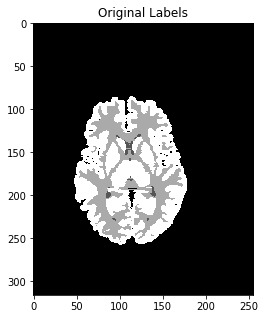

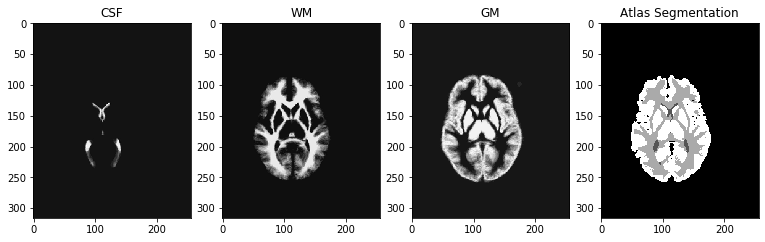

In [18]:
atlas_array = np.zeros((3,testing_image_vector.shape[0]),dtype=float)
atlas_array[0,:] = CSF_atlas_vector
atlas_array[1,:] = WM_atlas_vector
atlas_array[2,:] = GM_atlas_vector
out_atlas_vect = np.multiply(np.argmax(atlas_array, axis=0)+1,testing_mask_vector)
out_testing_labels_atlas = np.reshape(out_atlas_vect, testing_image.shape, order='F')

plt.figure(figsize=(5,5))
plt.title("Original Labels")
show_image(testing_labels[:,:,slice_no])

plt.figure(figsize=(13,13))
plt.subplot(1,4,1)
plt.title("CSF")
show_image(CSF_atlas[:,:,slice_no])
plt.subplot(1,4,2)
plt.title("WM")
show_image(WM_atlas[:,:,slice_no])
plt.subplot(1,4,3)
plt.title("GM")
show_image(GM_atlas[:,:,slice_no])
plt.subplot(1,4,4)
plt.title("Atlas Segmentation")
show_image(out_testing_labels_atlas[:,:,slice_no])

# Calculating Dice
dice_CSF, dice_GM, dice_WM = dice_similarity(out_testing_labels_atlas,testing_labels,"arr")
print("Atlas Dice: \n CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))

##Atlas Inside EM

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in log


Converging in iteration number:  100
Atlas inside EM Dice: 
 CSF DICE = 0.7005310171654386 GM DICE = 0.9580916549440605 WM DICE = 0.9346780519146228


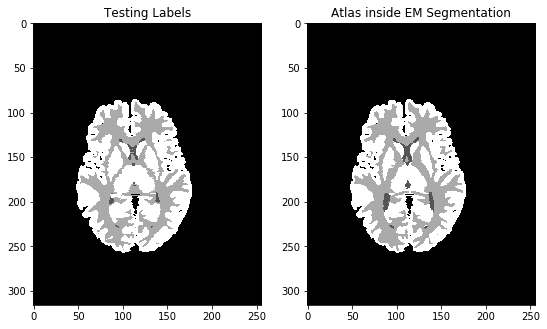

In [19]:
CSF_atlas_flatten =  ma.array(CSF_atlas,mask=~im_mask).compressed()
WM_atlas_flatten =  ma.array(WM_atlas,mask=~im_mask).compressed()
GM_atlas_flatten =  ma.array(GM_atlas,mask=~im_mask).compressed()

atlas_flatten_array = np.zeros((3,CSF_atlas_flatten.shape[0]),dtype=float)
atlas_flatten_array[0,:] = CSF_atlas_flatten
atlas_flatten_array[1,:] = WM_atlas_flatten
atlas_flatten_array[2,:] = GM_atlas_flatten
atlas_flatten_array_segmentation = np.argmax(atlas_flatten_array, axis=0)+1

testing_labels_flatten = ma.array(testing_labels,mask=~im_mask).compressed()

mu[0,:] = np.mean(ma.array(testing_image_flatten,mask=~(atlas_flatten_array_segmentation==1)).compressed())
mu[1,:] = np.mean(ma.array(testing_image_flatten,mask=~(atlas_flatten_array_segmentation==3)).compressed())
mu[2,:]= np.mean(ma.array(testing_image_flatten,mask=~(atlas_flatten_array_segmentation==2)).compressed())

membership_weights = np.zeros((X.shape[0], 3))
membership_weights[:,0] = (atlas_flatten_array_segmentation == 1)
membership_weights[:,1] = (atlas_flatten_array_segmentation == 3)
membership_weights[:,2] = (atlas_flatten_array_segmentation == 2)

Nk = np.array([np.sum(atlas_flatten_array_segmentation == 1),np.sum(atlas_flatten_array_segmentation == 3),np.sum(atlas_flatten_array_segmentation == 2)]);

for i in range(0, 3):
  dummy_var = (X-mu[i]).T

for i in range(0, 3):
  co[i] = (1/Nk[i])*np.matmul(np.multiply(membership_weights[:,i],(X-mu[i,:]).T),(X-mu[i,:])) 

ll_old = 0
for iter_idx in range(1,number_of_iterations+1):
  
  #Calculate the probability using the multivariate GMM equation
  mgd = np.zeros((X.shape[0], 3))

  for i in range(0, 3):
    mgd[:,i] = multivariate_normal(mean=mu[i],cov=co[i]).pdf(X)*alpha[i]

  mgd[:,0] = np.multiply(mgd[:,0], CSF_atlas_flatten)
  mgd[:,1] = np.multiply(mgd[:,1], GM_atlas_flatten)
  mgd[:,2] = np.multiply(mgd[:,2], WM_atlas_flatten)

  mgd_sum = np.sum(mgd,axis=1)

  #Calculate the membership weights
  for i in range(0, 3):
    membership_weights[:,i] =  np.divide(mgd[:,i],mgd_sum)



  membership_weights = np.where((membership_weights<0), 0, membership_weights) #Replace the nan values with 1/k
  #Calculate the new mixture weights parameters
  Nk = np.sum(membership_weights,axis=0)
  membership_weights = np.where(np.isnan(membership_weights), 1/3, membership_weights) #Replace the nan values with 1/k

  
  ll_new = np.sum(np.log(np.sum(mgd, axis=1))); 
  #print(np.abs(ll_new - ll_old) )
  if np.abs(ll_new - ll_old) < tol:
    break
  ll_old = ll_new 


  for i in range(0, 3):
    mu[i,:] = (1/Nk[i])*np.matmul(np.transpose(membership_weights[:,i]), X);
    co[i] = (1/Nk[i])*np.matmul(np.multiply(membership_weights[:,i],(X-mu[i,:]).T),(X-mu[i,:]))

  

#Predict the EM labels based on the membership weights values
EM_predict = np.zeros((X.shape[0], ))

for i in range(0,membership_weights.shape[0]):
  max_idx = np.where(membership_weights[i,:] == np.amax(membership_weights[i,:]))

  if (max_idx[0][0]==0):
      EM_predict[i]=1
  elif(max_idx[0][0]==2):
      EM_predict[i]=2
  else:
      EM_predict[i]=3

print("Converging in iteration number: ", iter_idx)

#Reconstruct and show the EM output image
EM_output_image = reconstruct_3D_image(testing_mask, EM_predict)

plt.figure(figsize=(9,9))
plt.subplot(1,2,1)
plt.title("Testing Labels")
show_image(testing_labels[:,:,slice_no])
plt.subplot(1,2,2)
plt.title("Atlas inside EM Segmentation")
show_image(EM_output_image[:,:,slice_no])

# Calculating Dice
dice_CSF, dice_GM, dice_WM = dice_similarity(EM_output_image,testing_labels,"arr")
print("Atlas inside EM Dice: \n CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))

##Tissue Models Only

Tissue Model Dice: 
 CSF DICE = 0.32452431289640593 GM DICE = 0.8361168234976424 WM DICE = 0.8152147413231157


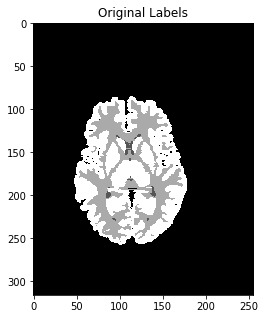

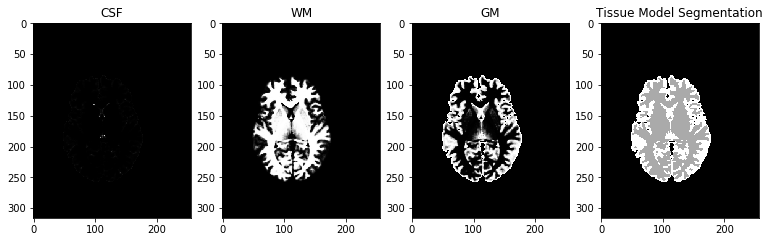

In [20]:
tissue_model_array = np.zeros((3,testing_image_vector.shape[0]),dtype=float)
tissue_model_array[0,:] = CSF_tissue_model_vector
tissue_model_array[1,:] = WM_tissue_model_vector
tissue_model_array[2,:] = GM_tissue_model_vector
out_tissue_model_vect = np.multiply(np.argmax(tissue_model_array, axis=0)+1,testing_mask_vector)
out_testing_labels_tissue_model = np.reshape(out_tissue_model_vect, testing_image.shape, order='F')

plt.figure(figsize=(5,5))
plt.title("Original Labels")
show_image(testing_labels[:,:,slice_no])

plt.figure(figsize=(13,13))
plt.subplot(1,4,1)
plt.title("CSF")
show_image(CSF_tissue_model[:,:,slice_no])
plt.subplot(1,4,2)
plt.title("WM")
show_image(WM_tissue_model[:,:,slice_no])
plt.subplot(1,4,3)
plt.title("GM")
show_image(GM_tissue_model[:,:,slice_no])
plt.subplot(1,4,4)
plt.title("Tissue Model Segmentation")
show_image(out_testing_labels_tissue_model[:,:,slice_no])

# Calculating Dice
dice_CSF, dice_GM, dice_WM = dice_similarity(out_testing_labels_tissue_model,testing_labels,"arr")
print("Tissue Model Dice: \n CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))

##Atlas + Tissue Models

Atlas + Tissue Models Dice: 
 CSF DICE = 0.6887156984740324 GM DICE = 0.9102733279746483 WM DICE = 0.8818970382525672


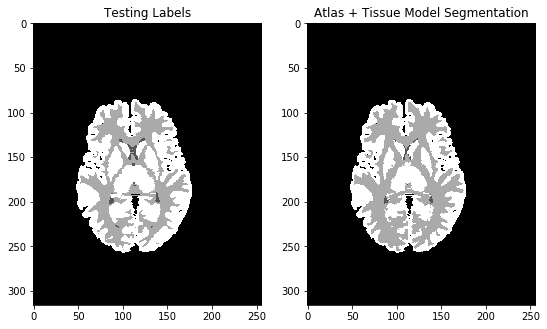

In [21]:
atlas_tissue_model_array = np.zeros((3,testing_image_vector.shape[0]),dtype=float)
atlas_tissue_model_array[0,:] = np.multiply(CSF_atlas_vector,CSF_tissue_model_vector)
atlas_tissue_model_array[1,:] = np.multiply(WM_atlas_vector,WM_tissue_model_vector)
atlas_tissue_model_array[2,:] = np.multiply(GM_atlas_vector,GM_tissue_model_vector)
out_testing_labels_vect = np.multiply(np.argmax(atlas_tissue_model_array, axis=0)+1,testing_mask_vector)
out_testing_labels_atlas_tissue_model = np.reshape(out_testing_labels_vect, testing_image.shape, order='F')

plt.figure(figsize=(9,9))
plt.subplot(1,2,1)
plt.title("Testing Labels")
show_image(testing_labels[:,:,slice_no])
plt.subplot(1,2,2)
plt.title("Atlas + Tissue Model Segmentation")
show_image(out_testing_labels_atlas_tissue_model[:,:,slice_no])

# Calculating Dice
dice_CSF, dice_GM, dice_WM = dice_similarity(out_testing_labels_atlas_tissue_model,testing_labels,"arr")
print("Atlas + Tissue Models Dice: \n CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))

##Atlas + EM

Atlas + EM Dice: 
 CSF DICE = 0.6581907448796395 GM DICE = 0.9576948291143975 WM DICE = 0.92581795759929


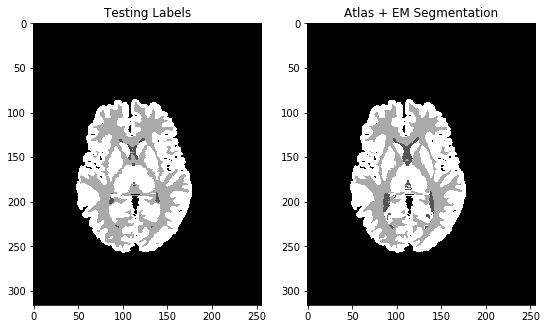

In [22]:
atlas_EM_array = np.zeros((3,testing_image_vector.shape[0]),dtype=float)
atlas_EM_array[0,:] = np.multiply(CSF_atlas_vector,CSF_EM_vector)
atlas_EM_array[1,:] = np.multiply(WM_atlas_vector,WM_EM_vector)
atlas_EM_array[2,:] = np.multiply(GM_atlas_vector,GM_EM_vector)
out_testing_labels_vect = np.multiply(np.argmax(atlas_EM_array, axis=0)+1,testing_mask_vector)
out_testing_labels_atlas_EM = np.reshape(out_testing_labels_vect, testing_image.shape, order='F')

plt.figure(figsize=(9,9))
plt.subplot(1,2,1)
plt.title("Testing Labels")
show_image(testing_labels[:,:,slice_no])
plt.subplot(1,2,2)
plt.title("Atlas + EM Segmentation")
show_image(out_testing_labels_atlas_EM[:,:,slice_no])

# Calculating Dice
dice_CSF, dice_GM, dice_WM = dice_similarity(out_testing_labels_atlas_EM,testing_labels,"arr")
print("Atlas + EM Dice: \n CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))